In [8]:
import pickle
from hist import Hist
import hist
import numpy as np
from matplotlib import pyplot as plt
ZMASS=91.1876
#from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
#from coffea.nanoevents.schemas.schema import auto_schema

In [9]:
import mplhep as hep
import awkward as ak
plt.style.use(hep.style.CMS)

def select_best_z(lep_posi,lep_nega,z_mass = ZMASS,verbose=False):
	predicted_number_of_iterations = ak.max(ak.num(lep_posi) + ak.num(lep_nega)) // 2 
	## ak to be returned
	pairable_posi = None
	pairable_nega = None

	number_of_remaining_posileptons = ak.sum(ak.num(lep_posi))
	number_of_remaining_negaleptons = ak.sum(ak.num(lep_nega))
	if verbose:
		print(f"predicted_number_of_iterations = {predicted_number_of_iterations}")
		print(f"Posi leptons to be matched {number_of_remaining_posileptons}")
		print(f"Nega leptons to be matched {number_of_remaining_negaleptons}")
	
	while number_of_remaining_negaleptons != 0 and number_of_remaining_posileptons!=0:
		## all possible combinations of lep_posi lep_nega, HAS repetitions
		var1,var2 = ak.unzip(ak.cartesian([lep_posi,lep_nega]))
		## build parent particle candidates, HAS repetitions
		Zcandidates = build_candidates(var1,var2)
		z_candidates_masses = Zcandidates.mass
        
        ## pick at most 1 candidate per event
        ## the one built from the lepton pair
        ## having the closest invariant mass 
        ## to the actual Z mass
        
        ## index of the best Z per event, None if empty
		best_z_index = ak.argmin(abs(z_candidates_masses-z_mass),axis=-1,keepdims =True)
        ## indices specifying for each cartesian pair
        ## the original index in the event
		indices = ak.argcartesian({"posi":lep_posi,"nega":lep_nega})
        ## fill output containers
		if pairable_posi is None:
			pairable_posi = var1[best_z_index]
		else:
			pairable_posi = ak.concatenate([pairable_posi,var1[best_z_index]],axis=-1)
		if pairable_nega is None:
			pairable_nega = var2[best_z_index]
		else:
			pairable_nega = ak.concatenate([pairable_nega,var2[best_z_index]],axis=-1)
		# dropping used muons
		lep_nega = ak.fill_none(lep_nega[ak.local_index(lep_nega)!=ak.flatten(indices[best_z_index].nega)],[],axis=-2)
		lep_posi = ak.fill_none(lep_posi[ak.local_index(lep_posi.mass)!=ak.flatten(indices[best_z_index].posi)],[],axis=-2)
		number_of_remaining_posileptons = ak.sum(ak.num(lep_posi))
		number_of_remaining_negaleptons = ak.sum(ak.num(lep_nega))
		if verbose:
			print(f"{number_of_remaining_negaleptons} remaing negative leptons")
			print(f"{number_of_remaining_posileptons} remaing positive leptons")

	pairable_posi = ak.drop_none(pairable_posi,axis=-1)
	pairable_nega = ak.drop_none(pairable_nega,axis=-1)


	
	return pairable_posi,pairable_nega

def attach_coffea_behavior(object_array):
    #new_coll = coll
    object_array["px"] = object_array.pt * np.cos(object_array.phi)
    object_array["py"] = object_array.pt * np.sin(object_array.phi)
    object_array["pz"] = object_array.pt * np.sinh(object_array.eta)
    object_array["E"] = np.sqrt(object_array.px**2 +object_array.py**2 +object_array.pz**2 +object_array.mass**2)
    return object_array
def build_candidates(array_daughter1,array_daughter2,events=None):
    observable_names = ["E","px","py","pz","charge"]
    
    if sum([obs in array_daughter1.fields for obs in observable_names]) != len(observable_names):
        array_daughter1 = attach_coffea_behavior(array_daughter1)
    if sum([obs in array_daughter2.fields for obs in observable_names]) != len(observable_names):
        array_daughter2 = attach_coffea_behavior(array_daughter2)
    
    candidates_observables = {}
    for k in observable_names:
        candidates_observables[k] = array_daughter1[k] + array_daughter2[k]
    candidates_observables["P"] = np.sqrt(candidates_observables["px"]**2 + candidates_observables["py"]**2 +candidates_observables["pz"]**2)
    candidates_observables["mass"] = np.sqrt(candidates_observables["E"]**2 - candidates_observables["P"]**2)
    
    candidates = ak.Array(candidates_observables)
    
    if events is not None:
        events["candidates"] = candidates
        return events
    else:
        return candidates

In [48]:
## load events
events1 = ak.from_parquet("events_zz_llll.parquet")
#events2 = ak.from_parquet("events_1.parquet")
#events = ak.concatenate([events1,events2])
events= events1

## add the original index number
## for future manipulation on 
## parents particles
for label in ["Muon","Electron"]:
    temp_m = events[label]
    temp_m["index"] = ak.local_index(events[label])
    events[label] = temp_m

In [49]:
## selecting lepton charges
muons_posi = events.Muon[events.Muon.charge > 0]
muons_nega = events.Muon[events.Muon.charge < 0]
elecs_posi = events.Electron[events.Electron.charge > 0]
elecs_nega = events.Electron[events.Electron.charge < 0]

## pairing Same Flavor leptons avoiding repetitions
pairable_muons_posi , pairable_muons_nega = select_best_z(muons_posi,muons_nega,z_mass = ZMASS)
pairable_elecs_posi , pairable_elecs_nega = select_best_z(elecs_posi,elecs_nega,z_mass = ZMASS)

## creating Z candidates
Zcandidates_muon = build_candidates(pairable_muons_posi , pairable_muons_nega)
Zcandidates_electron = build_candidates(pairable_elecs_posi , pairable_elecs_nega)
Zcandidates_muon["posi_lepton_index"] = pairable_muons_posi.index
Zcandidates_muon["nega_lepton_index"] = pairable_muons_nega.index
Zcandidates_electron["posi_lepton_index"] = pairable_elecs_posi.index
Zcandidates_electron["nega_lepton_index"] = pairable_elecs_nega.index

Zcandidates_muon["daughter_pair"] = ak.broadcast_arrays(0,Zcandidates_muon.E)[0]
Zcandidates_electron["daughter_pair"] = ak.broadcast_arrays(1,Zcandidates_electron.E)[0]
All_ZCandidates = ak.concatenate([Zcandidates_muon,Zcandidates_electron],axis=-1)
## adding to the event 
events["All_ZCandidates"] = All_ZCandidates

In [50]:
sort_index = ak.argsort(abs(events["All_ZCandidates"].mass-ZMASS),ascending=True)
events["All_ZCandidates"] = events["All_ZCandidates"][sort_index]
Double_Zevents = events[ak.num(events["All_ZCandidates"].mass)>=2]
Higgs_candidates = build_candidates(Double_Zevents["All_ZCandidates"][:,0],Double_Zevents["All_ZCandidates"][:,1])
Double_Zevents["Higgs_Candidate"] = Higgs_candidates
Double_Zevents["All_ZCandidates"] = Double_Zevents["All_ZCandidates"][:,0:2]

mask_SF_Muons = ak.all(Double_Zevents.All_ZCandidates.daughter_pair==0,axis=-1)
mask_SF_Electrons = ak.all(Double_Zevents.All_ZCandidates.daughter_pair==1,axis=-1)
mask_OF_Leptons = ~mask_SF_Muons | ~mask_SF_Electrons
mask_Z1gt40 = Double_Zevents.All_ZCandidates.mass[:,0]>40
mask_mll_in_12_120 = ak.all( (Double_Zevents.All_ZCandidates.mass>12) & (Double_Zevents.All_ZCandidates.mass<120),axis=-1)

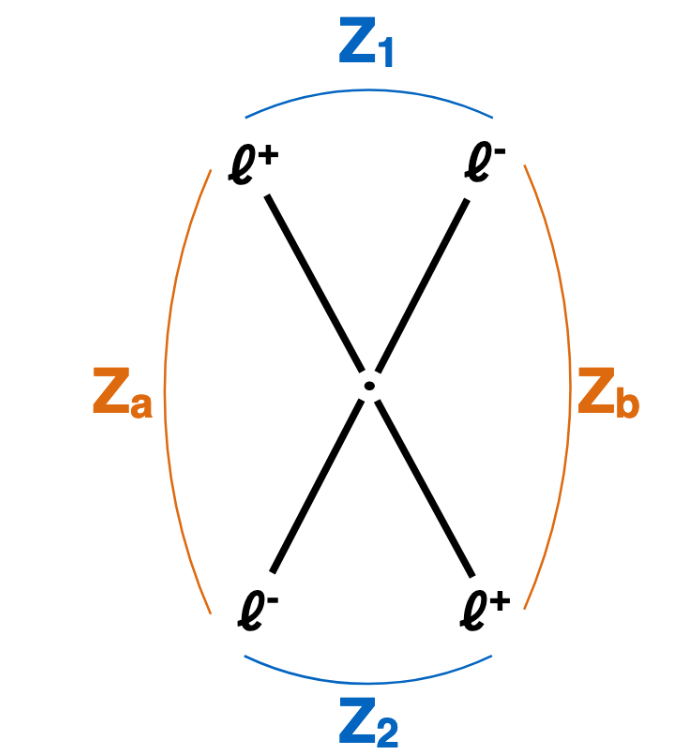

In [51]:
"""
For each Dobule_Z candidate the lepton flavour is tracked through 'daughter_pair' and the exact indices that were used to form it through 'nega_lepton_index'
Starting from Double Zs originated by same flavour leptons swap the pairs to build ZaZb

example

Z1(u+a,u-a) ,Z2 (u+b,u-b)
build
Za(u+a,u-b) ,Zb (u+b,u-a)
"""
from IPython.display import Image 
pil_img = Image(filename='Z1Za.png')
display(pil_img)

In [52]:
skip_masks = {}
SF_doubleZ_mask = {"Electrons":mask_SF_Electrons,"Muons":mask_SF_Muons}
collections = {"Electrons":"Electron","Muons":"Muon"}
ZaZb_candidates = {}
for label in ["Electrons","Muons"]:
    the_object = collections[label]
    the_events = Double_Zevents[SF_doubleZ_mask[label]]
    indices_nega = the_events.All_ZCandidates.nega_lepton_index
    indices_posi = the_events.All_ZCandidates.posi_lepton_index
    swap_pairs_indidces_nega = ak.concatenate([indices_nega[:,1:2],indices_nega[:,0:1]],axis=-1)

    DoubleZoff_LepNega = the_events[the_object][swap_pairs_indidces_nega]
    DoubleZoff_LepPosi = the_events[the_object][indices_posi]
    ZaZb = build_candidates(DoubleZoff_LepPosi,DoubleZoff_LepNega)
    ZaZb_candidates[label] = ZaZb


    print(f"For example the first 5 ZZ were built with \n\t Nega {label} idx {indices_nega[0:5]}\n\t Posi {label} idx {indices_posi[0:5]}\n\t Z1Z2 mass\t{the_events[0:5].All_ZCandidates.mass}\nWhile we will now use the following\n\t Nega {label} idx {swap_pairs_indidces_nega[0:5]}\n\t Posi {label} idx {indices_posi[0:5]}\n\t ZaZb mass\t{ZaZb[0:5].mass}")


    Skip_Z1Z2 = (abs(ZaZb[:,0].mass - ZMASS) < abs(the_events.All_ZCandidates[:,0].mass-ZMASS)) & (ZaZb[:,1].mass < 12)
    skip_masks[label] = Skip_Z1Z2
    print(f"{ak.sum( skip_masks[label])} candidates ZZ from 4{label} should be skipped\n")

For example the first 5 ZZ were built with 
	 Nega Electrons idx [[1, 3], [3, 2], [2, 3], [0, 3], [0, 1]]
	 Posi Electrons idx [[2, 0], [1, 0], [1, 0], [2, 1], [2, 3]]
	 Z1Z2 mass	[[92.6, 34.1], [88, 87.4], [90.8, 92.3], [91.8, 88.4], [86.7, 81.3]]
While we will now use the following
	 Nega Electrons idx [[3, 1], [2, 3], [3, 2], [3, 0], [1, 0]]
	 Posi Electrons idx [[2, 0], [1, 0], [1, 0], [2, 1], [2, 3]]
	 ZaZb mass	[[88.5, 86.6], [67.3, 43.6], [22.9, 127], [140, 246], [80.8, 67.3]]
0 candidates ZZ from 4Electrons should be skipped

For example the first 5 ZZ were built with 
	 Nega Muons idx [[1, 2], [3, 4], [0, 1], [1, 2], [1, 0]]
	 Posi Muons idx [[3, 0], [0, 1], [2, 3], [3, 0], [2, 3]]
	 Z1Z2 mass	[[91.6, 90.3], [91.8, 90], [93.9, 72.5], [89, 94.3], [71.2, 66.6]]
While we will now use the following
	 Nega Muons idx [[2, 1], [4, 3], [1, 0], [2, 1], [0, 1]]
	 Posi Muons idx [[3, 0], [0, 1], [2, 3], [3, 0], [2, 3]]
	 ZaZb mass	[[135, 204], [123, 88.2], [32.1, 17.7], [54.2, 116], [68.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

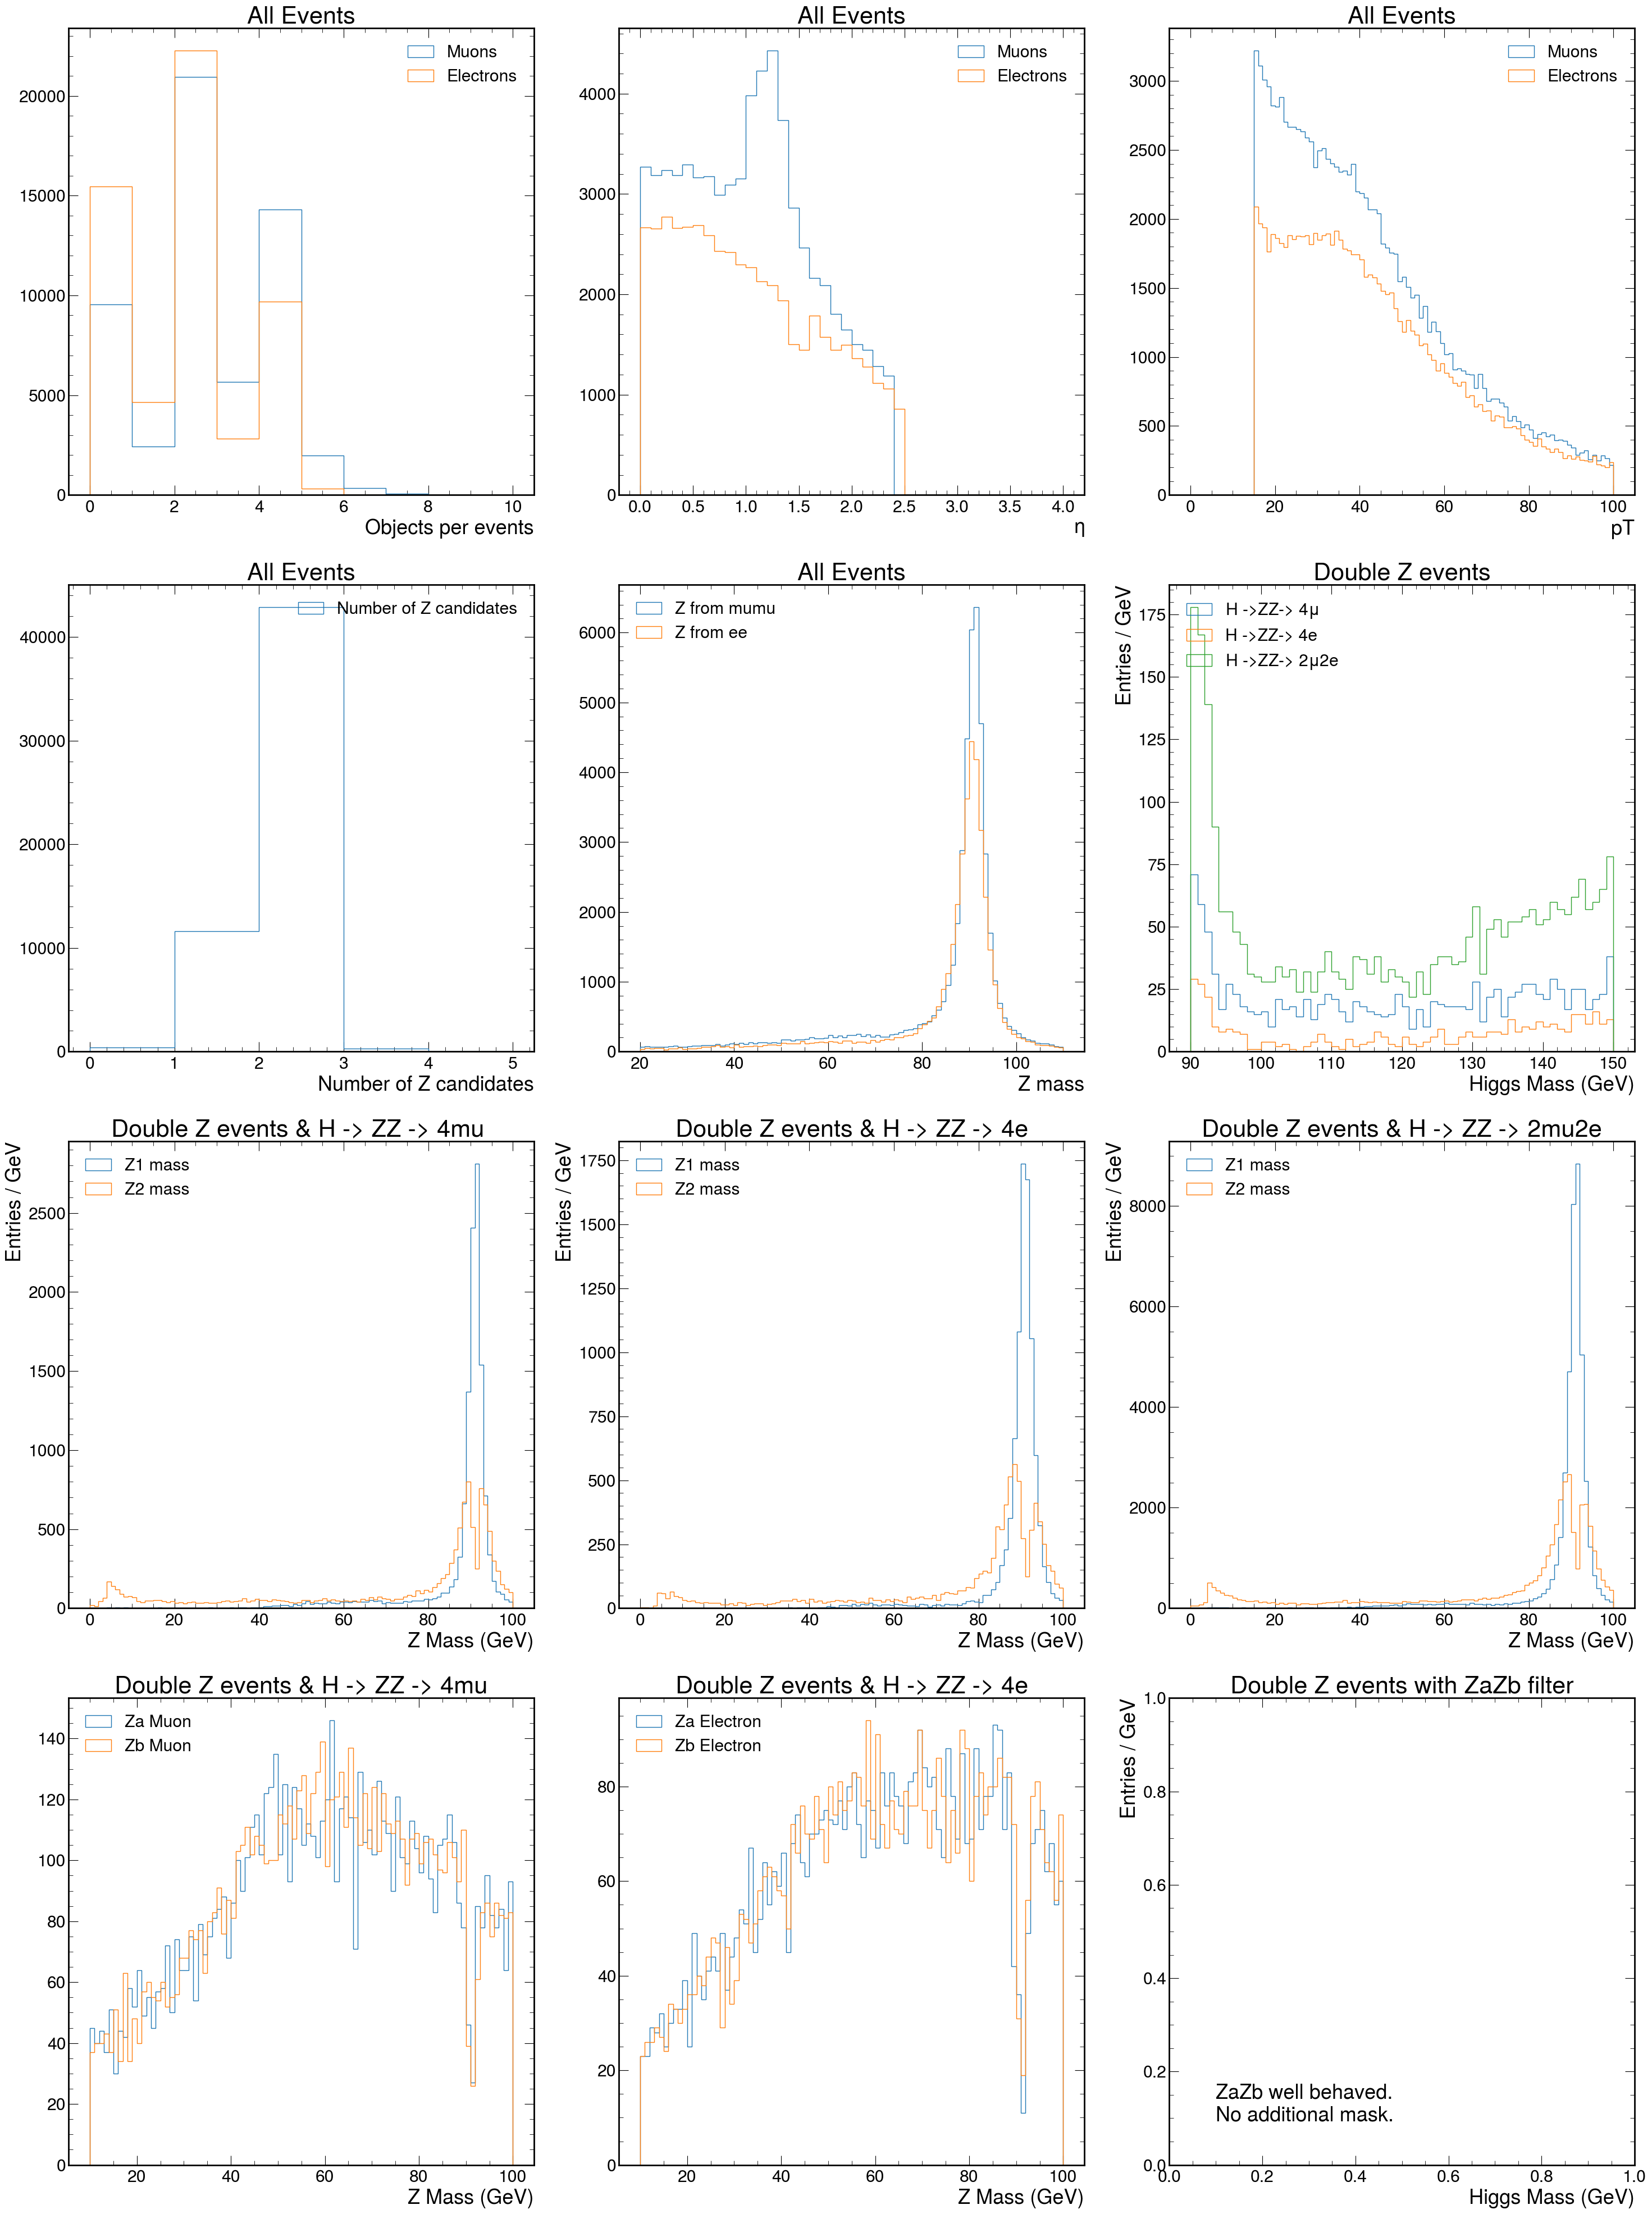

In [53]:
## summary plots
max,min = ak.max(ak.num(events["All_ZCandidates"].mass)),ak.min(ak.num(events["All_ZCandidates"].mass))
## leptons
fig,ax = plt.subplots(4,3,figsize=(30,40))
ax[0][0].hist(ak.ravel(ak.num(events.Muon.pt)),bins=10,range=(0,10),histtype="step",label="Muons")
ax[0][0].set_xlabel("Objects per events")
ax[0][0].set_title("All Events")
ax[0][1].hist(ak.ravel(events.Muon.eta),bins=40,range=(0,4),histtype="step",label="Muons")
ax[0][1].set_xlabel("$\eta$")
ax[0][1].set_title("All Events")
ax[0][2].hist(ak.ravel(events.Muon.pt),bins=100,range=(0,100),histtype="step",label="Muons")
ax[0][2].set_xlabel("$pT$")
ax[0][2].set_title("All Events")
ax[0][0].hist(ak.ravel(ak.num(events.Electron.pt)),bins=10,range=(0,10),histtype="step",label="Electrons")
ax[0][1].hist(ak.ravel(events.Electron.eta),bins=40,range=(0,4),histtype="step",label="Electrons")
ax[0][2].hist(ak.ravel(events.Electron.pt),bins=100,range=(0,100),histtype="step",label="Electrons")
ax[1][0].hist(ak.num(events["All_ZCandidates"].mass),label="Number of Z candidates",histtype="step",range=(0,max+1),bins=max+1)
ax[1][0].set_xlabel("Number of Z candidates")
ax[1][0].set_title("All Events")
for row in ax:
    for col in row:
        col.legend(loc="best")
    
## plot Z mass distribution for all Z candidates coming from mumu or ee
for idx,label in enumerate(["mumu","ee"]):
    jaggedarray = events["All_ZCandidates"][events["All_ZCandidates"].daughter_pair==idx].mass
    ax[1][1].hist(ak.ravel(jaggedarray),label=f"Z from {label}",histtype="step",range=(20,110),bins=90)
ax[1][1].set_xlabel("Z mass")
ax[1][1].legend(loc="upper left")
ax[1][1].set_title("All Events")

ax[1][2].hist(ak.ravel(Higgs_candidates[mask_SF_Muons].mass),bins=60,range=(90,150),label="H ->ZZ-> 4$\mu$",histtype="step")
ax[1][2].hist(ak.ravel(Higgs_candidates[mask_SF_Electrons].mass),bins=60,range=(90,150),label="H ->ZZ-> 4e",histtype="step")
ax[1][2].hist(ak.ravel(Higgs_candidates[mask_OF_Leptons].mass),bins=60,range=(90,150),label="H ->ZZ-> 2$\mu2e$",histtype="step")

ax[1][2].set_xlabel("Higgs Mass (GeV)")
ax[1][2].set_ylabel("Entries / GeV")
ax[1][2].legend(loc="upper left")
ax[1][2].set_title("Double Z events")

ax[2][0].hist(ak.ravel(Double_Zevents[mask_SF_Muons]["All_ZCandidates"].mass[:,0]),bins=100,range=(0,100),label="Z1 mass",histtype="step")
ax[2][0].hist(ak.ravel(Double_Zevents[mask_SF_Muons]["All_ZCandidates"].mass[:,1]),bins=100,range=(0,100),label="Z2 mass",histtype="step")
ax[2][0].set_xlabel("Z Mass (GeV)")
ax[2][0].set_ylabel("Entries / GeV")
ax[2][0].set_title("Double Z events & H -> ZZ -> 4mu ")

ax[2][1].hist(ak.ravel(Double_Zevents[mask_SF_Electrons]["All_ZCandidates"].mass[:,0]),bins=100,range=(0,100),label="Z1 mass",histtype="step")
ax[2][1].hist(ak.ravel(Double_Zevents[mask_SF_Electrons]["All_ZCandidates"].mass[:,1]),bins=100,range=(0,100),label="Z2 mass",histtype="step")
ax[2][1].set_xlabel("Z Mass (GeV)")
ax[2][1].set_ylabel("Entries / GeV")
ax[2][1].set_title("Double Z events & H -> ZZ -> 4e")



ax[2][2].hist(ak.ravel(Double_Zevents[mask_OF_Leptons]["All_ZCandidates"].mass[:,0]),bins=100,range=(0,100),label="Z1 mass",histtype="step")
ax[2][2].hist(ak.ravel(Double_Zevents[mask_OF_Leptons]["All_ZCandidates"].mass[:,1]),bins=100,range=(0,100),label="Z2 mass",histtype="step")
ax[2][2].set_xlabel("Z Mass (GeV)")
ax[2][2].set_ylabel("Entries / GeV")
ax[2][2].set_title("Double Z events & H -> ZZ -> 2mu2e")


ax[3][0].hist(ak.ravel(ZaZb_candidates["Muons"].mass[:,0]),bins=90,range=(10,100),label="Za Muon",histtype="step")
ax[3][0].hist(ak.ravel(ZaZb_candidates["Muons"].mass[:,1]),bins=90,range=(10,100),label="Zb Muon",histtype="step")
ax[3][0].set_title("Double Z events & H -> ZZ -> 4mu")
ax[3][0].set_xlabel("Z Mass (GeV)")
ax[3][1].hist(ak.ravel(ZaZb_candidates["Electrons"].mass[:,0]),bins=90,range=(10,100),label="Za Electron",histtype="step")
ax[3][1].hist(ak.ravel(ZaZb_candidates["Electrons"].mass[:,1]),bins=90,range=(10,100),label="Zb Electron",histtype="step")
ax[3][1].set_title("Double Z events & H -> ZZ -> 4e")
ax[3][1].set_xlabel("Z Mass (GeV)")
for i in range(2,4):
    for col in ax[i]:
        col.legend(loc="upper left")


if ak.sum(skip_masks["Electrons"]) == 0 and ak.sum(skip_masks["Muons"]) == 0:
    ax[3][2].text(0.1, 0.1, "ZaZb well behaved.\nNo additional mask.", ha='left', wrap=True)
else:
    ax[3][2].hist(ak.ravel(Higgs_candidates[mask_SF_Muons][~skip_masks["Muons"]].mass),bins=60,range=(90,150),label="H ->ZZ-> 4$\mu$",histtype="step")
    ax[3][2].hist(ak.ravel(Higgs_candidates[mask_SF_Electrons][~skip_masks["Electrons"]].mass),bins=60,range=(90,150),label="H ->ZZ-> 4e",histtype="step")
    ax[3][2].hist(ak.ravel(Higgs_candidates[mask_OF_Leptons].mass),bins=60,range=(90,150),label="H ->ZZ-> 2$\mu2e$",histtype="step")

ax[3][2].set_xlabel("Higgs Mass (GeV)")
ax[3][2].set_ylabel("Entries / GeV")
ax[3][2].legend(loc="upper left")
ax[3][2].set_title("Double Z events with ZaZb filter")

""" 2D Scatter plot of Z masses
x = ak.ravel(Double_Zevents["All_ZCandidates"].mass[:,0])
y = ak.ravel(Double_Zevents["All_ZCandidates"].mass[:,1])
# fill the axes
h = Hist(
    hist.axis.Regular(100, 0, 100, name="leading Z mass", label="Z1 mass [GeV]", underflow=True, overflow=True),
    hist.axis.Regular(100, 0, 100, name="sub-leading Z mass", label="Z2 mass [GeV]", underflow=True, overflow=True),
    ).fill(x.to_numpy(), y.to_numpy())
_ = h.plot2d(cmap="inferno",ax=ax[2,2])
ax[2,2].set_title(f"Double Z events")
"""
fig.tight_layout()

In [97]:
one = ak.Array([["mu1+", "mu2+", "mu3+"]])
two = ak.Array([["mu1-", "mu2-"]])

event = 0
s = ak.cartesian([one,two])
comb_one = ak.unzip(s)[0].to_list()
comb_two = ak.unzip(s)[1].to_list()
for idx,k in enumerate(ak.unzip(s)[0].to_list()):
    print(comb_one[idx])
    print(comb_two[idx])
    print()

['mu1+', 'mu1+', 'mu2+', 'mu2+', 'mu3+', 'mu3+']
['mu1-', 'mu2-', 'mu1-', 'mu2-', 'mu1-', 'mu2-']



In [78]:
one.type

ArrayType(ListType(ListType(NumpyType('uint8', parameters={'__array__': 'char'}, typestr='char'), parameters={'__array__': 'string'}, typestr='string')), 4)

In [109]:
#print(pickle.__version__)
print("hist version ", hist.__version__)
print("numpy version ",np.__version__)
print("matplotlib version ",matplotlib.__version__)

hist version  2.6.2
numpy version  1.22.1
matplotlib version  3.5.2


In [108]:
import matplotlib


'3.5.2'